In [1]:
import os
import sys
import glob
sys.path.append('../')

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from src.controllers.tile import TileController
from src.controllers.raster import RasterController
from src.layers.dict_class import LandCoverClassDict
from src.layers.utilities import plot_confusion_matrix

In [4]:
dict_class = LandCoverClassDict()

In [5]:
class_names = dict_class.get_landsat_dictionary()
class_names

{0: 'Sin Clasificar',
 1: 'Bosque',
 2: 'Cuerpo de Agua',
 3: 'Otras Tierras',
 4: 'Tierra Agropecuaria',
 5: 'Vegetacion Arbustiva y Herbacea',
 6: 'Zona Antropica'}

In [6]:
colors_class = dict_class.get_colors_dictionary()
colors_class

{0: (0, 0, 0),
 1: (62, 178, 49),
 2: (0, 0, 251),
 3: (122, 125, 74),
 4: (245, 106, 0),
 5: (255, 165, 81),
 6: (255, 0, 0)}

In [7]:
raster = RasterController()

In [8]:
label_path = '../data/images/processed/labels/landsat/LANDCOVER-ECUADOR-2020.tif'
gonzanama_path = '../data/images/processed/products/landsat/Cantones/milagros'

In [9]:
dataset_labels = raster.open_raster(raster=label_path)

Number of bands in the image: 1

Image size: 23910 rows x 21908 columns

Raster driver: GTiff

Image projection:
 EPSG:32617



In [10]:
tile_date = ['2018']
landsat_datasets = {}
for date in tile_date:
    tile_datasets = []
    date_paths = glob.glob(os.path.join(gonzanama_path, date, '*'))
    date_paths.sort()
    for tile_path in date_paths:
        tile_datasets.append(raster.open_raster(tile_path))
    landsat_datasets['2018'] = tile_datasets

Number of bands in the image: 8

Image size: 479 rows x 433 columns

Raster driver: GTiff

Image projection:
 EPSG:32617

Number of bands in the image: 8

Image size: 479 rows x 433 columns

Raster driver: GTiff

Image projection:
 EPSG:32617

Number of bands in the image: 8

Image size: 479 rows x 433 columns

Raster driver: GTiff

Image projection:
 EPSG:32617

Number of bands in the image: 8

Image size: 479 rows x 433 columns

Raster driver: GTiff

Image projection:
 EPSG:32617



In [11]:
landsat_datasets

{'2018': [<open DatasetReader name='../data/images/processed/products/landsat/Cantones/milagros/2018/LC08_L1TP_010063_20190606_20200828_02_T1_MC.tif' mode='r'>,
  <open DatasetReader name='../data/images/processed/products/landsat/Cantones/milagros/2018/LC08_L1TP_010063_20190825_20200826_02_T1_MC.tif' mode='r'>,
  <open DatasetReader name='../data/images/processed/products/landsat/Cantones/milagros/2018/LC08_L1TP_010063_20190926_20200825_02_T1_MC.tif' mode='r'>,
  <open DatasetReader name='../data/images/processed/products/landsat/Cantones/milagros/2018/LC08_L1TP_010063_20200608_20200824_02_T1_MC.tif' mode='r'>]}

In [12]:
from keras.models import load_model
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score

2024-01-10 16:44:30.304460: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-10 16:44:30.609601: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-10 16:44:31.296900: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/theend/miniconda3/envs/soil-env/lib/python3.8/site-packages/nvidia/cudnn/lib:/home/theend/miniconda3/envs/soil-env/lib/:/usr/local/cuda-11.8/lib64:
2024-01-10 16:44:31.297033: W tensorflow/stream_executor/p

In [13]:
model_h5 = load_model('../models/v5/landsat.h5')
model_h5.summary()

2024-01-10 16:44:32.057176: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-10 16:44:32.095084: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-10 16:44:32.095349: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-10 16:44:32.095814: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        2048      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 64)       2

In [14]:
def make_all_pixels(tile):
    points = []
    l8_points = []
    x = np.arange(0, 1085, 1)
    y = np.arange(0, 1049, 1)
    for row in y:
        for col in x:
            point = (row, col)
            points.append(point)
    for point in points:
        l8_points.append((point, tile))
    return l8_points

In [15]:
all_px = make_all_pixels('2018')
all_px[:10]

[((0, 0), '2018'),
 ((0, 1), '2018'),
 ((0, 2), '2018'),
 ((0, 3), '2018'),
 ((0, 4), '2018'),
 ((0, 5), '2018'),
 ((0, 6), '2018'),
 ((0, 7), '2018'),
 ((0, 8), '2018'),
 ((0, 9), '2018')]

In [16]:
len(all_px)

1138165

In [17]:
tile_size = 32
tile_gen = TileController(landsat_datasets, dataset_labels, tile_size, tile_size, all_px, 100)

In [19]:
predictions = model_h5.predict(
    next(tile_gen),
    steps=len(all_px) // 100,
    verbose=1,
)

2024-01-10 16:59:49.300335: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600


    3/11381 [..............................] - ETA: 16:11  

2024-01-10 16:59:49.980487: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


11381/11381 [==============================] - 2773s 244ms/step


In [20]:
def complete_missing_pixels(predictions):
    """Completa los pixeles faltantes de una matriz con 0.

    Args:
        predictions: La matriz con las predicciones.

    Returns:
        La matriz con los pixeles completados.
    """

    # Obtener el número de filas y columnas de la matriz.
    num_rows, num_cols = predictions.shape

    # Completar los pixeles faltantes con 0.
    predictions = np.pad(predictions, ((0, 65),(0,0)), mode='constant', constant_values=(0,))

    return predictions


predictions_completed = complete_missing_pixels(predictions)

In [21]:
predictions.shape

(1138100, 7)

In [22]:
predictions_completed = complete_missing_pixels(predictions)

In [23]:
predictions_completed.shape

(1138165, 7)

In [24]:
array = np.argmax(predictions_completed, axis=1)

In [25]:
array.shape

(1138165,)

In [26]:
np.unique(array)

array([0, 2, 3, 4, 5, 6])

In [27]:
re_sd = array.reshape(1085, 1049)

In [28]:
re_sd.shape

(1085, 1049)

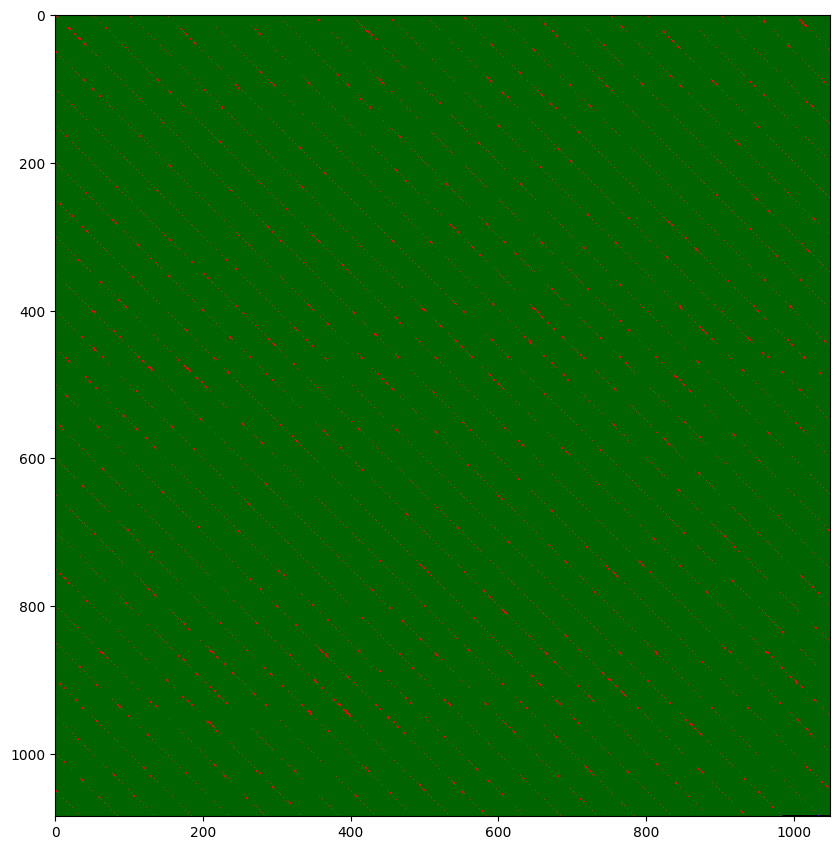

In [29]:
from matplotlib import colors

# Build a listed colormap.
c_map = colors.ListedColormap(['black', 'blue', 'red', 'darkgreen', 'saddlebrown', 'bisque', 'purple'])
bounds = [0, 1, 2, 3, 4, 5, 6]
norm = colors.BoundaryNorm(bounds, c_map.N)

fig, axs = plt.subplots(figsize=(10,12))

# Plot the image with a color bar
axs = plt.imshow(re_sd, cmap=c_map, norm=norm)

In [30]:
eval_generator = next(
    TileController(gonzanama_raster, dataset_labels, 32, 32, all_px, 1)
)

NameError: name 'gonzanama_raster' is not defined

In [ ]:
labels = np.empty(predictions.shape)
count = 0
while count < len(labels):
    image_b, label_b = next(eval_generator)
    labels[count] = label_b
    count += 1

label_index = np.argmax(labels, axis=1)
pred_index = np.argmax(predictions, axis=1)

np.set_printoptions(precision=2)

In [ ]:
pred_index.shape

In [ ]:
_ = plot_confusion_matrix(
    label_index,
    pred_index,
    class_dict=class_names,
    title='Confusion matrix - Normalized',
    normalize=True
)

In [ ]:
print(f'Accuracy: {(accuracy_score(label_index, pred_index)*100):.2f}%')
print(f'Precision: {(precision_score(label_index, pred_index, average="weighted")*100):.2f}%')
print(f'Recall: {(recall_score(label_index, pred_index, average="weighted")*100):.2f}%')
print(f'F1 score: {(f1_score(label_index, pred_index, average="weighted")*100):.2f}%')